In [ ]:
# default_exp inspect

In [ ]:
# export
from typing import Iterable, Optional, Sequence

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [ ]:
from IPython.display import HTML
import sklearn.datasets
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge
from sklearn.model_selection import GridSearchCV, KFold

In [ ]:
# hide
%reload_ext autoreload
%autoreload 2
%load_ext lab_black

# inspect

> Inspect models.

In [ ]:
# hide
from nbdev.showdoc import *

In [ ]:
# export
def generate_linear_model_html(
    model,
    feature_names: Iterable[str],
    target_name: str,
    intercept_formatter: str = ".2f",
    coef_formatter: str = ".2f",
):
    """Generate an HTML equation that characterizes a linear model.

    Model components are color-coded as follows:
    - target: red
    - intercept: purple
    - coefficients: green
    - features: blue

    Parameters:
    - `model`: fitted scikit-learn linear model of the form
    `y = b0 + b1 * x1 + ...`.
    - `feature_names`: feature names in the order in which they were
    given to the model.
    - `target_name` : Name of target variable `y`
    - `intercept_formatter`: Format specifier for model intercept
    - `coef_formatter`: Format specifier for model coefficients
    """
    if len(model.coef_) != len(feature_names):
        raise ValueError("len(model.coef_) != len(feature_cols)")
    model_string = f"""
        <span style='color:red'>{target_name}</span>
        = <span style='color:purple'>{model.intercept_:{intercept_formatter}}</span>
    """
    for coef, feature_col in zip(model.coef_, feature_names):
        model_string += f"""
            <span style='color:green'>{"+" if coef >= 0 else "-"} {abs(coef):{coef_formatter}}</span>
            * <span style='color:blue'>{feature_col}</span>
        """
    return model_string

In [ ]:
X_diabetes, y_diabetes = sklearn.datasets.load_diabetes(return_X_y=True, as_frame=True)

HTML(
    generate_linear_model_html(
        model=LinearRegression().fit(X_diabetes, y_diabetes),
        feature_names=X_diabetes.columns,
        target_name="progression",
    )
)

In [ ]:
# export
def generate_logistic_model_html(
    model,
    feature_names: Iterable[str],
    target_val_names: Iterable[str],
    intercept_formatter: str = ".2f",
    coef_formatter: str = ".2f",
):
    """Generate an HTML equation that characterizes a logistic
    regression model.

    Model components are color-coded as follows:
    - target: red
    - intercept: purple
    - coefficients: green
    - features: blue

    Parameters:
    - `model`: fitted scikit-learn linear model of the form
    `log-odds(y) = b0 + b1 * x1 + ...`.
    - `feature_names`: feature names in the order in which they were
    given to the model.
    - `target_val_names`: Names of the values of the target variable
    - `intercept_formatter`: Format specifier for model intercept
    - `coef_formatter`: Format specifier for model coefficients
    """
    for coefs in model.coef_:
        if len(coefs) != len(feature_names):
            raise ValueError("len(model.coef_) != len(feature_cols)")
    model_string = "<p>"
    for target_name, coefs, intercept in zip(
        target_val_names, model.coef_, model.intercept_
    ):
        model_string += f"""
            <span style='color:red'>log-odds({target_name})</span>
            = <span style='color:purple'>{intercept:{intercept_formatter}}</span>
        """
        for coef, feature_col in zip(coefs, feature_names):
            model_string += f"""
                <span style='color:green'>{"+" if coef >= 0 else "-"} {abs(coef):{coef_formatter}}</span>
                * <span style='color:blue'>{feature_col}</span>
            """
        model_string += "</p>"
    return model_string

In [ ]:
iris = sklearn.datasets.load_iris()
X_iris, y_iris = iris["data"], iris["target"]
X_iris = pd.DataFrame(X_iris, columns=iris["feature_names"])

lr_iris = LogisticRegression(max_iter=1_000).fit(X_iris, y_iris)
HTML(
    generate_logistic_model_html(
        model=lr_iris,
        feature_names=X_iris.columns,
        target_val_names=iris["target_names"],
    )
)

In [ ]:
# export
def plot_2d_linear_regression(model, X: pd.DataFrame, y: Sequence):
    """Plot data and predictions for linear regression model with two
    features

    Parameters:
    - `model`: scikit-learn linear model of the form
    `y = b0 + b1 * x1 + ...`.
    - `X`: Feature matrix with at least two columns. The first two
    columns will be used.
    - `y`: Target values
    """
    x_grid = np.linspace(X.iloc[:, 0].min(), X.iloc[:, 0].max(), 100)
    y_grid = np.linspace(X.iloc[:, 1].max(), X.iloc[:, 1].min(), 100)

    preds = (
        model.fit(X, y)
        .predict(
            np.transpose([np.tile(x_grid, len(y_grid)), np.repeat(y_grid, len(x_grid))])
        )
        .reshape(len(y_grid), len(x_grid))
    )
    preds = pd.DataFrame(preds, columns=x_grid, index=y_grid)
    ax = sns.heatmap(preds, cmap="viridis", vmin=y.min(), vmax=y.max())

    X_normalized = MinMaxScaler().fit_transform(X) * 99
    ax.scatter(
        X_normalized[:, 0] + 0.5,
        X_normalized[:, 1].max() - X_normalized[:, 1] + 0.5,
        c=y,
    )
    ax.set(xlabel=X.columns[0], ylabel=X.columns[1])
    return ax

In [ ]:
feature_cols = ["bmi", "bp"]
HTML(
    generate_linear_model_html(
        LinearRegression().fit(X_diabetes.loc[:, feature_cols], y_diabetes),
        feature_cols,
        "progression",
    )
)

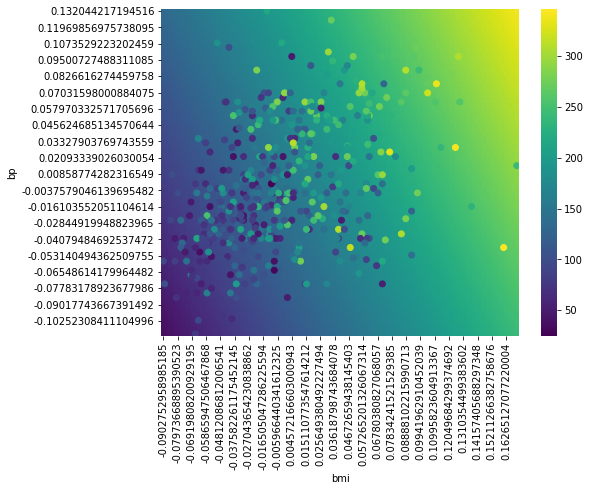

In [ ]:
ax = plot_2d_linear_regression(
    model=LinearRegression(),
    X=X_diabetes.loc[:, feature_cols],
    y=y_diabetes,
)
ax.get_figure().set_size_inches((8, 6))

In [ ]:
# export
def plot_2d_binary_logistic_regression(
    model, X: pd.DataFrame, y: Sequence, label_names: Optional[Sequence[str]] = None
):
    """Plot decision boundary of a logistic regression model with two
    features and a binary target

    Parameters:
    - `model`: fitted scikit-learn logistic regression model
    - `X`: Feature matrix
    - `y`: 0/1 target values
    - `label_names`: strings labels for target values 0 and 1,
    respectively
    """
    fig, ax = plt.subplots()
    for color, y_val in zip(("orange", "b"), (0, 1)):
        X.loc[y == y_val, :].plot.scatter(
            x=X.columns[0],
            y=X.columns[1],
            alpha=0.3,
            label=label_names[y_val] if label_names else y_val,
            ax=ax,
            color=color,
        )

    boundary_x = np.array([X.iloc[:, 0].min(), X.iloc[:, 0].max()])
    boundary_y = (-1.0 / model.coef_[0, 1]) * (
        model.coef_[0, 0] * boundary_x + model.intercept_
    )
    ax.plot(boundary_x, boundary_y, label="Model decision boundary", c="k")

    ax.set(
        ylim=[X.iloc[:, 1].min() - 0.1 * X.iloc[:, 1].max(), X.iloc[:, 1].max() * 1.1],
        xlim=[X.iloc[:, 0].min() - 0.1 * X.iloc[:, 0].max(), X.iloc[:, 0].max() * 1.1],
    )

    # fmt: off
    ax.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left'); 
    return ax

In [ ]:
lr = LogisticRegression().fit(
    X_cancer.loc[:, ["mean radius", "mean texture"]], y_cancer,
)
# fmt: off
plot_binary_logistic_regression_decision_boundary(
    lr, X_cancer, y_cancer, label_names=["benign", "malignant"]
);

NameError: name 'X_cancer' is not defined

In [ ]:
# export
def plot_linear_coefs_vs_hparam(
    model, X: pd.DataFrame, y: Sequence, hparam: str, hparam_vals: Sequence[float]
):
    """Plot linear regression coefficients against a hyperparameter
    
    Parameters:
    - `model`: fitted scikit-learn linear model of the form
    `y = b0 + b1 * x1 + ...`.
    - `X`: Feature matrix
    - `y`: Target values
    - `hparam`: Name of hyperparameter
    - `hparam_vals`: Values of hyperparameter to use
    """
    setattr(model, hparam, hparam_vals[-1])
    model.fit(X, y)
    column_order = model.coef_.argsort()[::-1]
    X = X.iloc[:, column_order]

    coefs = []
    for val in hparam_vals:
        setattr(model, hparam, val)
        coefs.append(model.fit(X, y).coef_)

    fig, ax = plt.subplots()
    ax.plot(hparam_vals, coefs)
    ax.set(xlabel=hparam, ylabel="coefficient value")
    ax.legend(X.columns, bbox_to_anchor=(1.05, 1.0), loc="upper left")
    return ax

In [ ]:
grid_ridge_diabetes = GridSearchCV(
    estimator=Ridge(),
    param_grid={"alpha": np.logspace(-2, -0.8, 20)},
    cv=KFold(10, shuffle=True, random_state=2),
)
grid_ridge_diabetes.fit(X_diabetes, y_diabetes)
ax = (
    pd.DataFrame(grid_ridge_diabetes.cv_results_)
    .loc[:, ["param_alpha", "mean_test_score"]]
    .plot(x="param_alpha")
)
# fmt: off
ax.set_ylabel("Accuracy");

In [ ]:
from sklearn.linear_model import Ridge

# fmt: off
ax = plot_linear_coefs_vs_hparam(
    model=Ridge(),
    X=X_diabetes,
    y=y_diabetes,
    hparam="alpha",
    hparam_vals=np.logspace(-2, 0.5, 20),
)
ax.axvline(grid_ridge_diabetes.best_params_["alpha"], c="k");

In [ ]:
from sklearn.linear_model import Lasso

# fmt: off
plot_linear_coefs_vs_hparam(
    model=Lasso(max_iter=10_000_000),
    X=X_diabetes,
    y=y_diabetes,
    hparam="alpha",
    hparam_vals=np.logspace(-2, 0.5, 20),
);

In [ ]:
from sklearn.linear_model import ElasticNet

# fmt: off
plot_linear_coefs_vs_hparam(
    model=ElasticNet(alpha=3),
    X=X_diabetes,
    y=y_diabetes,
    hparam="l1_ratio",
    hparam_vals=np.linspace(0, 1, 11),
);

In [ ]:
# export
def plot_logistic_coefs_vs_hparam(
    model, X: pd.DataFrame, y: Sequence, hparam: str, hparam_vals: Sequence[float]
):
    """Plot logistic regression coefficients against a hyperparameter
    
    Parameters:
    - `model`: fitted scikit-learn linear model of the form
    `log-odds(y) = b0 + b1 * x1 + ...`.
    - `X`: Feature matrix
    - `y`: Target values
    - `hparam`: Name of hyperparameter
    - `hparam_vals`: Values of hyperparameter to use
    """
    setattr(model, hparam, hparam_vals[-1])
    column_order = model.fit(X, y).coef_[0].argsort()[::-1]
    X = X.iloc[:, column_order]

    coef_arrays = []
    for val in hparam_vals:
        setattr(model, hparam, val)
        coef_arrays.append(model.fit(X, y).coef_)

    num_target_vals = len(set(y))
    if num_target_vals == 2:
        fig, ax = plt.subplots()
        ax.plot(hparam_vals, [coefs[0] for coefs in coef_arrays])
        axes = np.array(ax)[None]
    else:
        fig, axes = plt.subplots(
            num_target_vals, 1, sharex=True, sharey=True, constrained_layout=True
        )
        for target_val_num in range(num_target_vals):
            axes[target_val_num].plot(
                hparam_vals, [coefs[target_val_num] for coefs in coef_arrays]
            )
            axes[target_val_num].set_title(f"y={sorted(set(y))[target_val_num]}")
    axes[0].legend(X.columns, bbox_to_anchor=(1.05, 1.0), loc="upper left")
    axes[0].set_ylabel("Coefficient Value")
    axes[-1].set_xlabel(hparam)
    return axes

In [ ]:
X_cancer, y_cancer = sklearn.datasets.load_breast_cancer(return_X_y=True, as_frame=True)
axes = plot_logistic_coefs_vs_hparam(
    model=LogisticRegression(max_iter=10_000),
    X=X_cancer,
    y=y_cancer,
    hparam="C",
    hparam_vals=np.logspace(-1, 2, 10),
)

In [ ]:
axes = plot_logistic_coefs_vs_hparam(
    model=LogisticRegression(max_iter=1_000),
    X=X_iris,
    y=y_iris,
    hparam="C",
    hparam_vals=np.logspace(-2, 0, 20),
)

In [ ]:
axes = plot_logistic_coefs_vs_hparam(
    model=LogisticRegression(max_iter=1_000, solver="liblinear", penalty="l1"),
    X=X_iris,
    y=y_iris,
    hparam="C",
    hparam_vals=np.logspace(-2, 0, 20),
)

In [ ]:
axes = plot_logistic_coefs_vs_hparam(
    model=LogisticRegression(
        max_iter=10_000, solver="saga", penalty="elasticnet", C=0.1
    ),
    X=X_iris,
    y=y_iris,
    hparam="l1_ratio",
    hparam_vals=np.linspace(0, 1, 11),
)

In [ ]:
# hide
from nbdev.export import *

notebook2script()